## 7. Group Assignment & Presentation

In [261]:
# Standard libraries
import os
import re
import random
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, RandomRotation
from tensorflow.keras.models import Sequential
from keras.applications import VGG16
from keras.models import Model

# Matplotlib inline setting
%matplotlib inline

### 1. Analysis: Frame the problem and look at the big picture

1. There is a lot of newcomers in the gyms and a lot of them do not know what each machine is used for, or what exercises they can train using those machines.
2. We have decided to create an algorithm that will classify the gym equipment that could then be used to provide them with exercises (our scope is just classification).
3. The problem is framed as a supervised learning problem, where we have labeled images of different gym equipment.
4. The performance measures will include accuracy, precision, recall and confusion matrix.

### 2. Get the data
We got the data, pictures of selected gym equipment, from https://www.kaggle.com/datasets/teguhbudi/gym-tools.
We have checked that all of the categories of the gym equipment had 30 pictures, but "step" and "gymball".
We added one picture from each to mach the amount of data gathered for each category.

### 3. Explore the data
1. Loading images.
2. Identifying and setting the targets
3. Visualizing sample images.
4. Analyzing number of images, its shape.
5. Checking number of images and label distribution.
6. Analyzing image statistics.
7. Visualizing data augumentation applied later to the dataset.

In [262]:
# Ensuring reproducibility
np.random.seed(0)
tf.random.set_seed(0)

def load_images_and_labels(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            match = re.match(r"([a-zA-Z]+)", filename)
            if match:
                label = match.group(1)
                img_path = os.path.join(folder, filename)
                img = Image.open(img_path).convert('L')  # Converting to grayscale
                img = img.resize((64, 64), Image.LANCZOS)  # Resizing to 64 x 64 using LANCZOS filter
                img_array = np.array(img) / 255.0  # Normalizing pixel values
                img_flattened = img_array.flatten()  # Flattening to 1D array
                images.append(img_flattened)
                labels.append(label)
            else:
                print(f"Skipping file with invalid format: {filename}")
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

# Path to image folder
folder_path = r'images' 

# Loading images and labels
data, target = load_images_and_labels(folder_path)

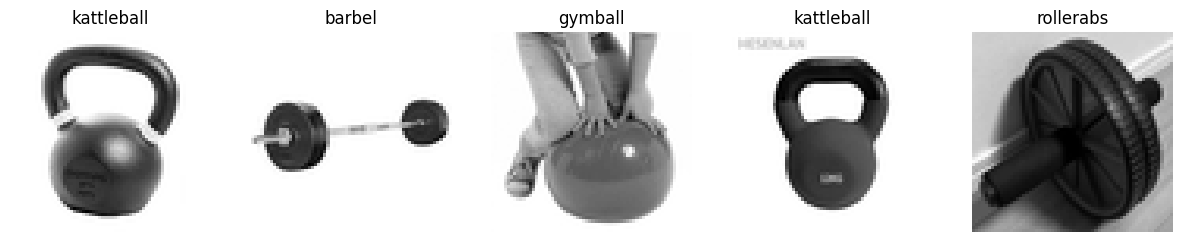

In [263]:
# Visualizing sample images

def visualize_samples(images, labels, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        index = np.random.randint(0, len(images))
        img = images[index].reshape(64, 64)
        label = labels[index]
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()


visualize_samples(data, target)

In [264]:
# Analyzing metadata
def analyze_image_metadata(images):
    print(f"Number of images: {len(images)}")
    print(f"Image shape: {images[0].shape}")
    print(f"Data type: {images.dtype}")


analyze_image_metadata(data)

Number of images: 500
Image shape: (4096,)
Data type: float64


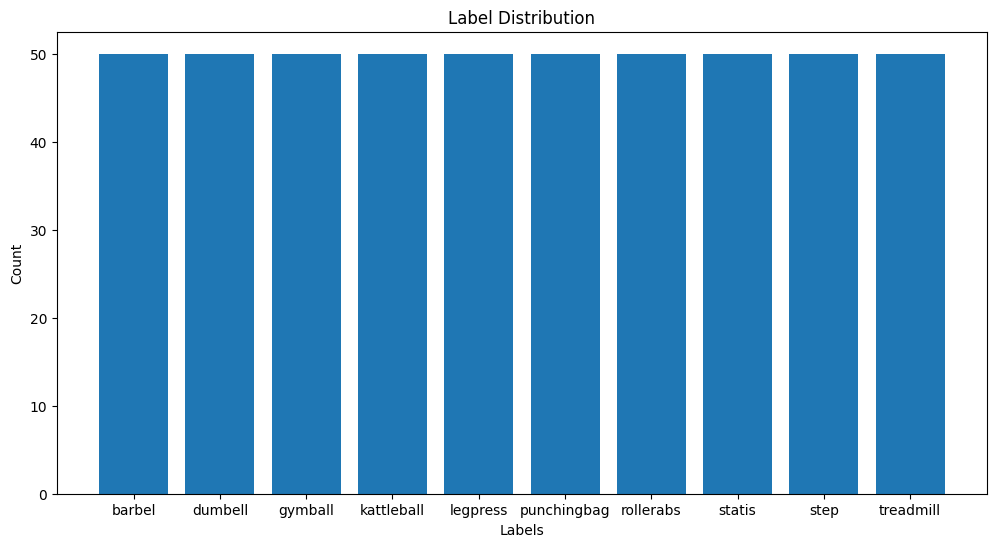

In [265]:
# Analyzing label distribution
def analyze_label_distribution(labels):
    label_counts = Counter(labels)
    plt.figure(figsize=(12, 6))  # Adjust the width and height as needed
    plt.bar(label_counts.keys(), label_counts.values())
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Label Distribution')
    plt.show()

analyze_label_distribution(target)

In [266]:
# Computing image statistics
def compute_image_statistics(images):
    pixel_values = images.flatten()
    mean = np.mean(pixel_values)
    std_dev = np.std(pixel_values)
    print(f"Mean pixel value: {mean}")
    print(f"Standard deviation of pixel values: {std_dev}")


compute_image_statistics(data)
#The standard deviation shows that there's some variety in pixel intensities, but not extreme.

Mean pixel value: 0.6972043160232844
Standard deviation of pixel values: 0.3251326100324729


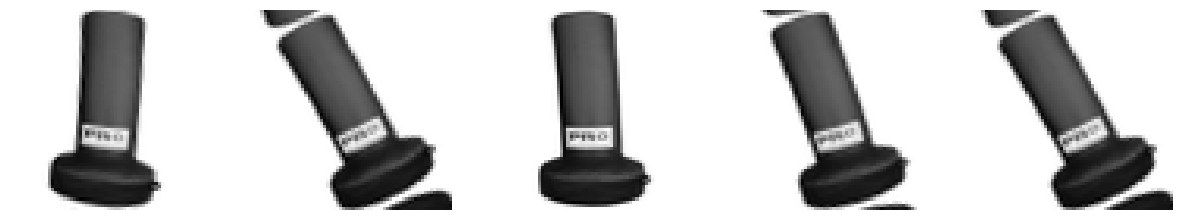

In [267]:
# Visualizing augmentation that will be performed on the dataset
def visualize_augmentation_effects(image, data_aug, num_samples=5):
    img = image.reshape(1, 64, 64, 1)

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        augmented_image = data_aug(img)[0].numpy()
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(augmented_image.reshape(64, 64), cmap='gray')
        plt.axis('off')
    plt.show()

# Defining the data augmentation layer
data_aug = models.Sequential([
    RandomRotation(0.1)
])

# Path to image folder (using raw string to avoid unicode escape errors)
folder_path = r'images'  # Replace with the path to your folder

# Loading your images and labels
data, target = load_images_and_labels(folder_path)

# Converting labels to categorical format
unique_labels = list(set(target))

# Visualizing the augmentation effects
random_index = np.random.randint(0, len(data))
visualize_augmentation_effects(data[random_index], data_aug)

### 4. Prepare the data
1. Encoding labels as integers
2. Mapping original labels to numerical encoding
3. Augumentation of data

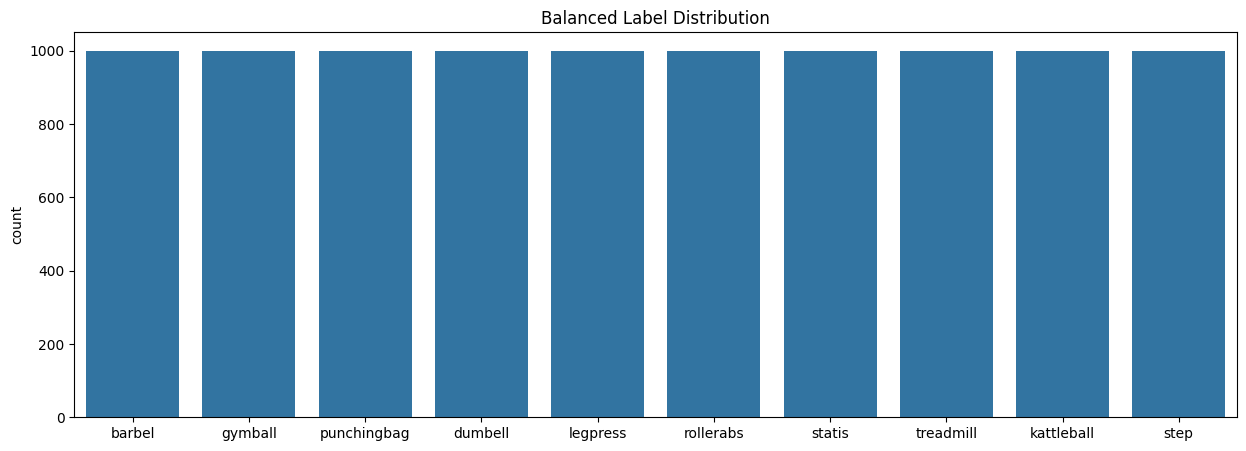

In [268]:
unique_labels = list(set(target))

# Creating a mapping from labels to indices
unique_labels = list(set(target))
label_to_index = {label: index for index, label in enumerate(unique_labels)}
index_to_label = {index: label for label, index in label_to_index.items()}

# Data augmentation layer
data_aug = Sequential([
    RandomRotation(0.1, input_shape=(64, 64, 1))
])

target_bal = 1000  # Desired number of samples per class

# Balancing dataset
augmented_data = []
augmented_labels = []

for label in unique_labels:
    label_indices = [i for i, l in enumerate(target) if l == label]
    label_count = len(label_indices)
    
    if label_count < target_bal:
        fill_count = target_bal - label_count
        
        for _ in range(fill_count):
            # Randomly picking an image from the existing images of the current label
            random_index = random.choice(label_indices)
            image = data[random_index].reshape((64, 64, 1))  # Ensuring the correct shape
            
            # Applying augmentation
            augmented_image = data_aug(np.expand_dims(image, axis=0))[0].numpy()
            
            augmented_data.append(augmented_image)
            augmented_labels.append(label)
    
    # Including original images
    for idx in label_indices:
        augmented_data.append(data[idx].reshape((64, 64, 1)))  # Ensure the correct shape
        augmented_labels.append(label)

# Converting to numpy arrays
augmented_data = np.array(augmented_data)
augmented_labels = np.array(augmented_labels)

# Plotting the distribution of augmented labels
plt.subplots(figsize=(15, 5))
sns.countplot(x=[label for label in augmented_labels])
plt.title("Balanced Label Distribution")
plt.show()

In [269]:
# Encoding labels as integers
label_encoder = LabelEncoder()
y_augmented_encoded = label_encoder.fit_transform(augmented_labels)

# Converting to one-hot encoding
y_augmented_categorical = to_categorical(y_augmented_encoded, num_classes=len(unique_labels))

# Reshaping data for CNN input (64x64x1)
X_augmented_reshaped = augmented_data.reshape(-1, 64, 64, 1)

# Encoding labels as integers
label_encoder = LabelEncoder()
y_augmented_encoded = label_encoder.fit_transform(augmented_labels)

# Converting to one-hot encoding
y_augmented_categorical = to_categorical(y_augmented_encoded, num_classes=len(unique_labels))

# Reshaping data for KNN (flatten the images)
X_augmented_flattened = augmented_data.reshape(len(augmented_data), -1)

### 5. Short-list promising models

 - KNN
 - Random Forest
 - CNN
 - VGG16

#### K-nearest Neighbours

In [270]:
#Splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(X_augmented_flattened, y_augmented_encoded, test_size=0.25, random_state=42)

for i in range(5, 20):    
    # Creating KNN classifier
    knn = KNeighborsClassifier(n_neighbors=i)
    
    # Training the classifier
    knn.fit(X_train, y_train)
    
    train_accuracy = accuracy_score(y_train, knn.predict(X_train))
    test_accuracy = accuracy_score(y_test, knn.predict(X_test))
    
    print(i, round(train_accuracy,3), round(test_accuracy,3), round(train_accuracy-test_accuracy,4))

5 0.982 0.952 0.03
6 0.956 0.919 0.0375
7 0.956 0.92 0.0363
8 0.921 0.874 0.0461
9 0.919 0.874 0.0456
10 0.88 0.829 0.0505
11 0.88 0.831 0.0492
12 0.844 0.788 0.0555
13 0.841 0.787 0.0536
14 0.809 0.746 0.0625
15 0.808 0.744 0.0639
16 0.778 0.715 0.0629
17 0.774 0.72 0.0537
18 0.753 0.699 0.0543
19 0.752 0.7 0.0516


## Confusion Matrix for KNN

Training Accuracy: 0.9824
Test Accuracy: 0.9524
Precision: 0.9593
Recall: 0.9524


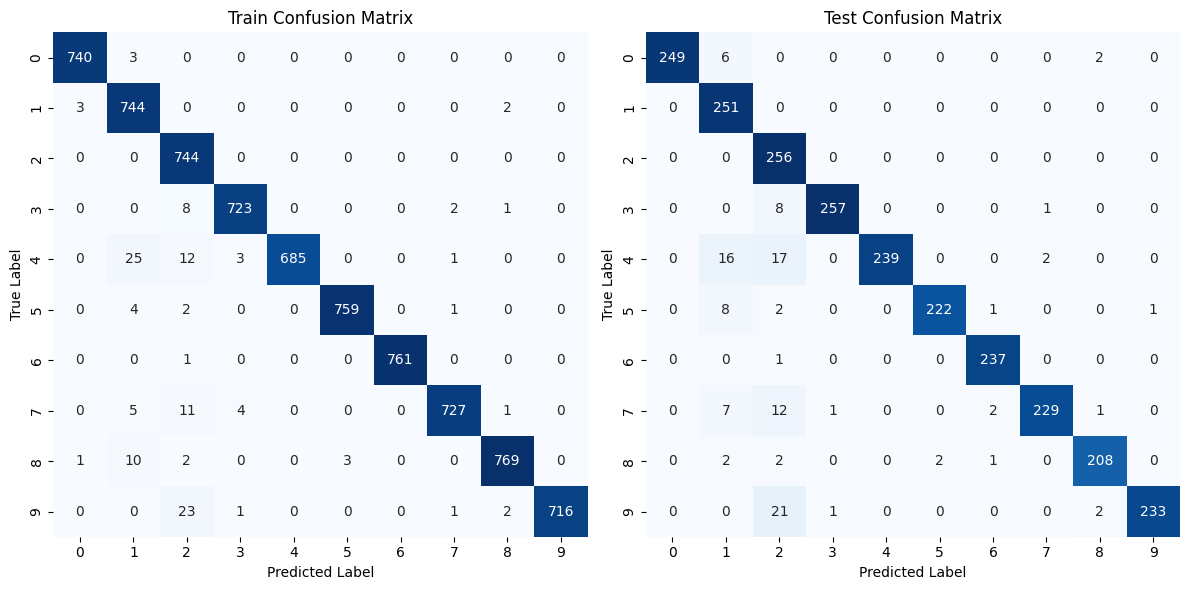

In [271]:
# Creating KNN classifier with number of neughbours = 5
knn = KNeighborsClassifier(n_neighbors=5)

# Training the classifier
knn.fit(X_train, y_train)

# Getting predictions on train and test data
train_predictions = knn.predict(X_train)
test_predictions = knn.predict(X_test)

# Evaluating accuracy on train and test data
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print("Training Accuracy:", round(train_accuracy, 4))
print("Test Accuracy:", round(test_accuracy, 4))

# Calculating precision, recall, score on test data
precision = precision_score(y_test, test_predictions, average='weighted')
recall = recall_score(y_test, test_predictions, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Generating confusion matrices
train_cm = confusion_matrix(y_train, train_predictions)
test_cm = confusion_matrix(y_test, test_predictions)

# Plotting confusion matrices
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Train Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.subplot(1, 2, 2)
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()


(13, 4096) (13,)
Test Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


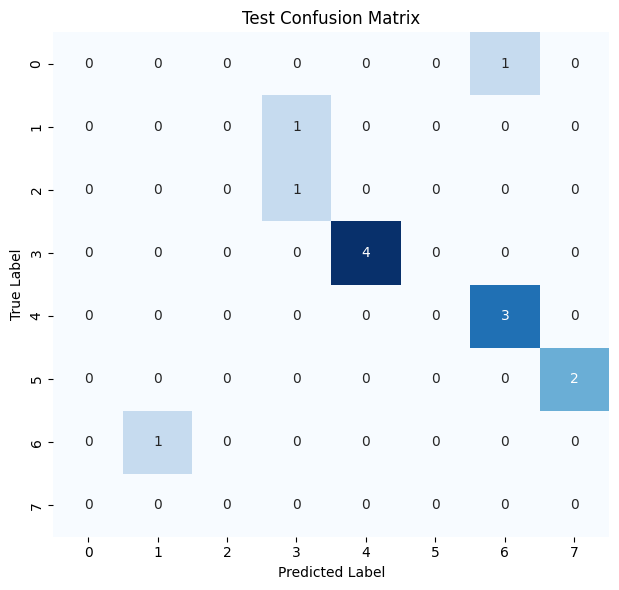

In [272]:
## Predictions on a test set
data, target = load_images_and_labels(r'test_images')

label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

print(data.shape, target.shape)

# Predicting the labels for the test set
test_predictions = knn.predict(data)

# Evaluating accuracy on the test data
test_accuracy = accuracy_score(target, test_predictions)

# Calculating precision, recall, and F1 score on test data
precision = precision_score(target, test_predictions, average='weighted')
recall = recall_score(target, test_predictions, average='weighted')
f1 = f1_score(target, test_predictions, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

test_cm = confusion_matrix(target, test_predictions)

# Plotting confusion matrices
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()

### Analysis of KNN

- At first we got a very good accuracy for KNN, but it performed very poorly on our test data
- It was most likely due to image augmentation that we did, and because KNN tries to find the best match, a "rotated" or slightly augmented picture will be correctly classified as the same, polluting the dataset and final result
- After only using the original data set, it showed a more reasonable accuracy of 45.04% and test accuracy 38.4%
- The model is still overfitting, and generally not performing very well during manual testing, so it is not a good model for this problem

#### Random Forest

In [273]:
# Splitting the augmented and encoded dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented_flattened, y_augmented_encoded, test_size=0.25, random_state=42)

# Initializing a large difference to compare later
train_test_difference = 100

# Looping through different values for n_estimators (number of trees) and max_depth (depth of trees)
for i in range(1, 10):
    for j in range(1, 6):
        # Initializing the Random Forest Classifier with current i and j values
        rf_classifier = RandomForestClassifier(n_estimators=i, max_depth=j, random_state=42)
        
        # Fitting the classifier on the training data
        rf_classifier.fit(X_train, y_train)
        
        # Calculating training accuracy
        train_accuracy_rf = accuracy_score(y_train, rf_classifier.predict(X_train))
        # Calculating testing accuracy
        test_accuracy_rf = accuracy_score(y_test, rf_classifier.predict(X_test))
        
        # Check if the difference between training and testing accuracy is less than 0.05
        if abs(train_accuracy_rf - test_accuracy_rf) < 0.05:
            # Print the parameters and accuracies if conditions are met
            print(i, j, train_accuracy_rf, test_accuracy_rf, abs(train_accuracy_rf - test_accuracy_rf))
            
            # Update the train_test_difference if the test accuracy is above 0.3
            if test_accuracy_rf > 0.3:
                train_test_difference = abs(train_accuracy_rf - test_accuracy_rf)


1 1 0.194 0.1988 0.004799999999999999
1 2 0.2942666666666667 0.2828 0.01146666666666668
1 3 0.36546666666666666 0.3568 0.008666666666666656
1 4 0.42746666666666666 0.4232 0.004266666666666641
1 5 0.4908 0.4636 0.027200000000000002
2 1 0.19826666666666667 0.2052 0.006933333333333319
2 2 0.3312 0.3168 0.014399999999999968
2 3 0.41333333333333333 0.4068 0.0065333333333333354
2 4 0.4888 0.4652 0.02360000000000001
2 5 0.5596 0.5388 0.02080000000000004
3 1 0.20626666666666665 0.2116 0.005333333333333357
3 2 0.3456 0.3292 0.016400000000000026
3 3 0.4185333333333333 0.4016 0.0169333333333333
3 4 0.5172 0.508 0.009199999999999986
3 5 0.6077333333333333 0.5836 0.02413333333333334
4 1 0.23466666666666666 0.2428 0.008133333333333326
4 2 0.35746666666666665 0.3408 0.016666666666666663
4 3 0.42546666666666666 0.392 0.033466666666666645
4 4 0.5104 0.4968 0.013599999999999945
4 5 0.6246666666666667 0.5896 0.03506666666666669
5 1 0.2288 0.2272 0.0015999999999999903
5 2 0.35973333333333335 0.3448 0.0149

In [274]:
# Creating Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=1, max_depth=7, random_state=42)

# Training the classifier
rf_classifier.fit(X_train, y_train)

# Evaluating accuracy on train data
train_accuracy_rf = accuracy_score(y_train, rf_classifier.predict(X_train))
print("Random Forest Training Accuracy:", round(train_accuracy_rf, 4))

# Evaluating accuracy on test data
test_accuracy_rf = accuracy_score(y_test, rf_classifier.predict(X_test))
print("Random Forest Test Accuracy:", round(test_accuracy_rf, 4))

# Calculating precision, recall on test data
precision_rf = precision_score(y_test, rf_classifier.predict(X_test), average='weighted')
recall_rf = recall_score(y_test, rf_classifier.predict(X_test), average='weighted')

print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")

Random Forest Training Accuracy: 0.6331
Random Forest Test Accuracy: 0.6072
Precision: 0.6149
Recall: 0.6072


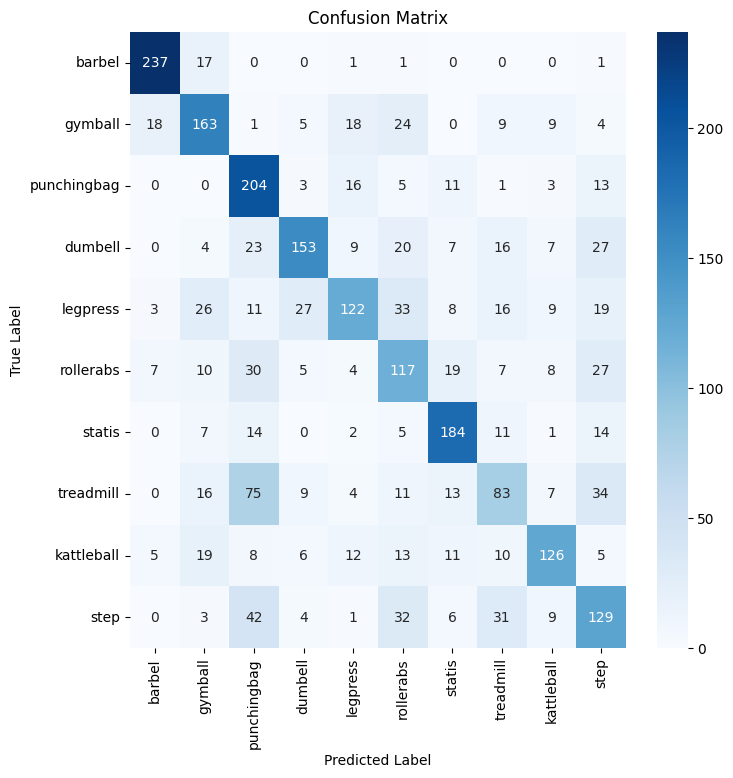

In [275]:
# Predicting the labels for the test set
Y_pred = rf_classifier.predict(X_test)

# Creating and plot the confusion matrix
cm = confusion_matrix(y_test, Y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Analysis of Random Forest

- The labels' classification accuracy was relatively low, as seen by the 46.11% and 43.28%, respectively, test and training accuracy. This implies that the model has difficulty efficiently capturing the patterns in the visual data.
- Handcrafted features or the raw pixel values are used as input by Random Forest. This method may not capture correctly the complex and hierarchical elements seen in the photos when it comes to image identification.
- The model's problems with grasping the complex links and the dependencies found in pictures may be limiting its performance.

### Convolutional Neural Network

In [276]:
# Splitting the data into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(X_augmented_reshaped, y_augmented_categorical, test_size=0.30, random_state=42)

# Splitting the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Initializing the Sequential model
model = models.Sequential()

# Adding the first convolutional layer with 64 filters, a 3x3 kernel, ReLU activation, and input shape (64x64x1)
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 1)))
# Adding a max pooling layer with 2x2 pool size
model.add(layers.MaxPooling2D((2, 2)))
# Adding a dropout layer to prevent overfitting
model.add(layers.Dropout(0.25))  

# Adding a second convolutional layer with 64 filters and a 3x3 kernel
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Adding another max pooling layer with 2x2 pool size
model.add(layers.MaxPooling2D((2, 2)))
# Adding another dropout layer
model.add(layers.Dropout(0.25)) 

# Adding a third convolutional layer with 64 filters and a 3x3 kernel
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Flatten the output to feed into the dense layers
model.add(layers.Flatten())

# Adding a dense layer with 128 units and ReLU activation
model.add(layers.Dense(128, activation='relu'))
# Adding another dropout layer
model.add(layers.Dropout(0.5))  

# Adding a dense output layer with a number of units equal to the number of unique labels, using softmax activation
model.add(layers.Dense(len(unique_labels), activation='softmax'))

# Compiling the model with the Adam optimizer, categorical cross-entropy loss, and accuracy as a metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model with the training data, using a 30% validation split and 5 epochs
history = model.fit(X_train, y_train, epochs = 5, batch_size = 64, validation_split = 0.3, verbose = 1)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/5


c:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.1849 - loss: 2.1556 - val_accuracy: 0.6657 - val_loss: 1.1171
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5623 - loss: 1.2675 - val_accuracy: 0.7657 - val_loss: 0.6433
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.6979 - loss: 0.8260 - val_accuracy: 0.8852 - val_loss: 0.3980
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7751 - loss: 0.6021 - val_accuracy: 0.9305 - val_loss: 0.2400
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8530 - loss: 0.4168 - val_accuracy: 0.9524 - val_loss: 0.1654
Test loss: 0.1670
Test accuracy: 0.9493


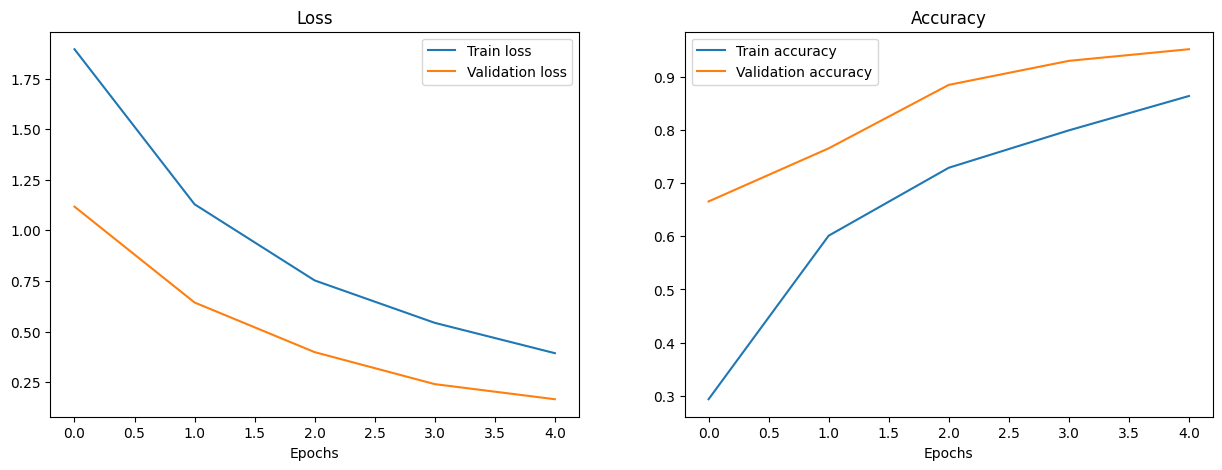

In [277]:
# Plotting the loss and accuracy over epochs
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history.history["loss"], label="Train loss")
ax[0].plot(history.history["val_loss"], label="Validation loss")
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[0].legend()

ax[1].plot(history.history["accuracy"], label="Train accuracy")
ax[1].plot(history.history["val_accuracy"], label="Validation accuracy")
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].legend()

plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy: 0.9493
Precision: 0.9514
Recall: 0.9493


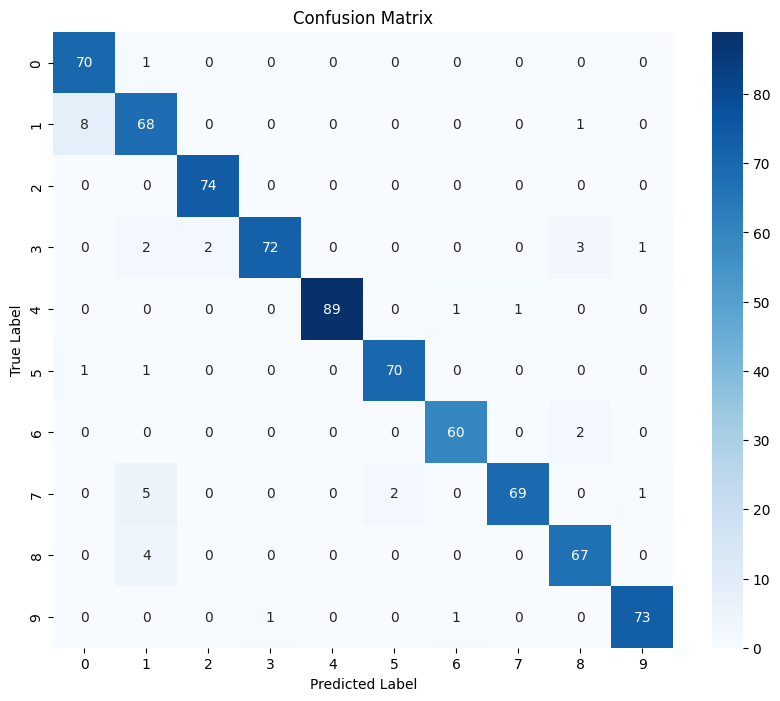

In [278]:
# Predicting the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculating accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Creating and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


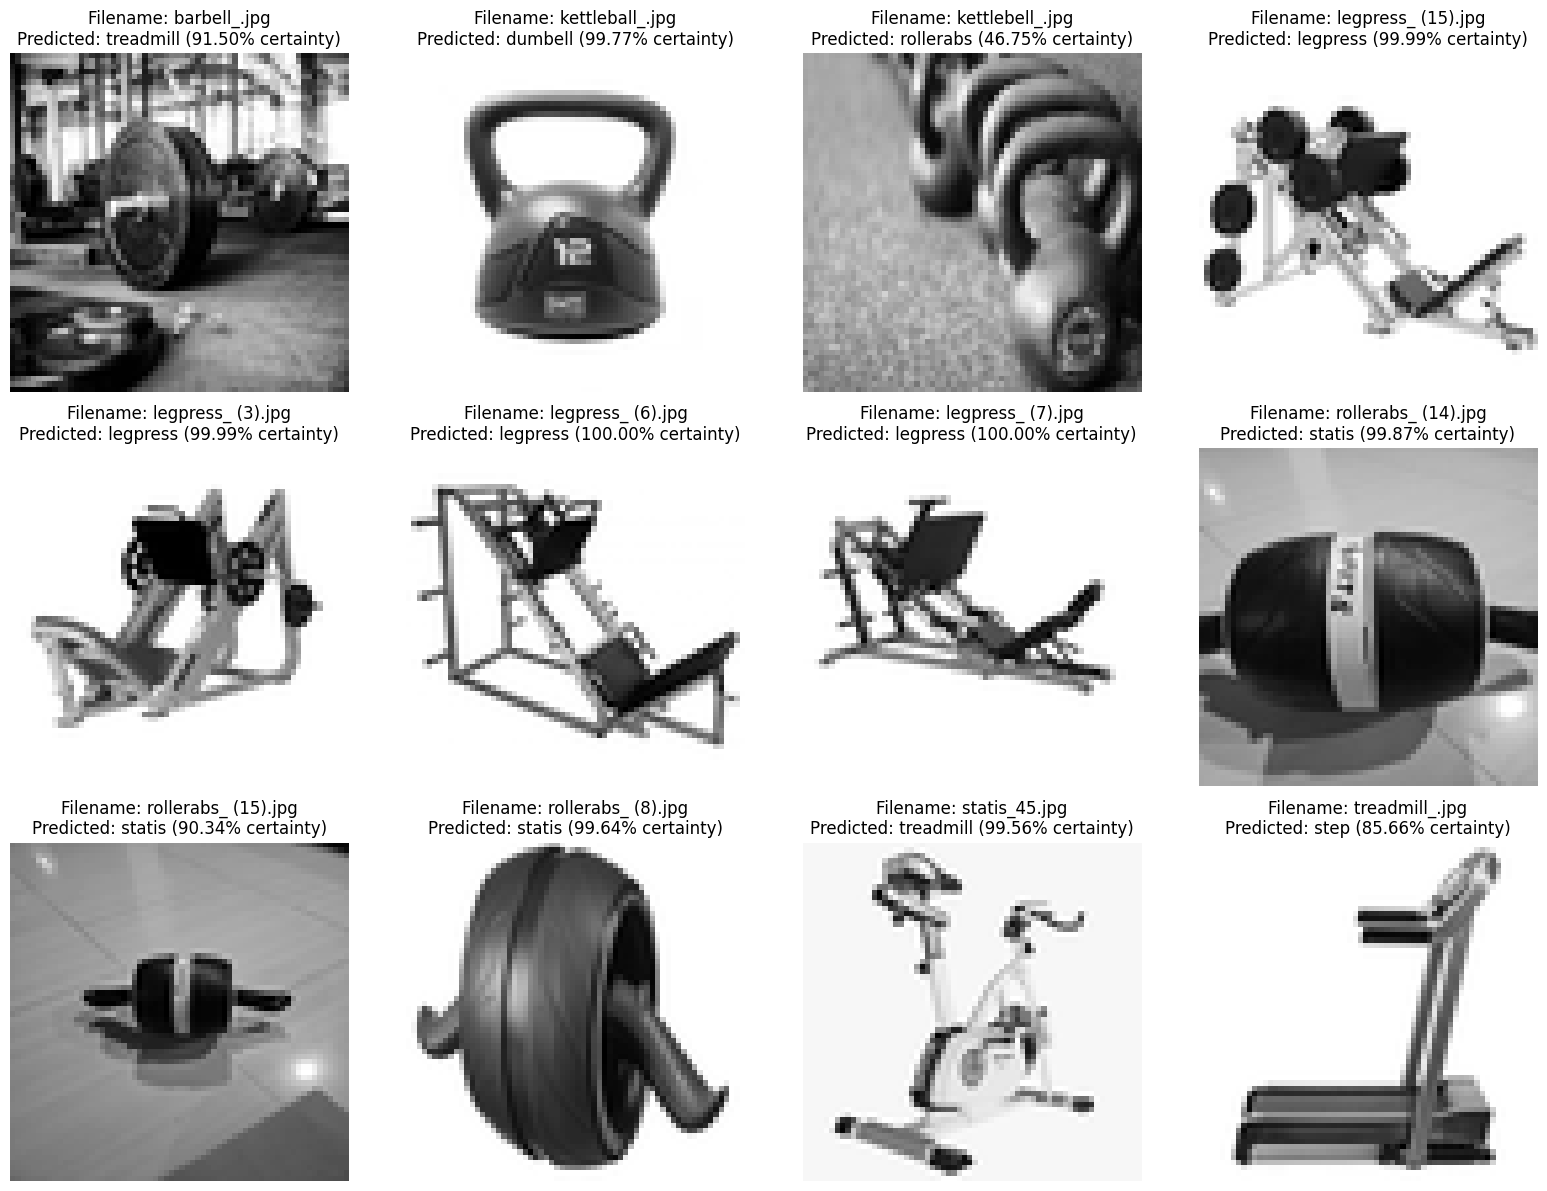

In [279]:
def preprocess_image(image_path):
    # Loading the image
    img = Image.open(image_path).convert('L')  # Converting to grayscale
    img = img.resize((64, 64), Image.LANCZOS)  # Resizing to 64x64
    img_array = np.array(img) / 255.0  # Normalizing to [0, 1]
    img_array = np.expand_dims(img_array, axis=-1)  # Adding an extra dimension for the color channel
    return img_array

def preprocess_images_from_folder(folder_path):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder_path, filename)
            img_array = preprocess_image(img_path)
            images.append(img_array)
            filenames.append(filename)
    return np.array(images), filenames


folder_path = 'test_images' 
test_images, filenames = preprocess_images_from_folder(folder_path)

# Making predictions with the trained model
predictions = model.predict(test_images)

# Converting predictions to class labels and get the prediction confidence
predicted_labels = np.argmax(predictions, axis=1)
prediction_confidences = np.max(predictions, axis=1)

# Function to display predictions
def display_predictions(images, predictions, confidences, filenames, labels_map, max_images_per_row=4):
    num_images = len(images)
    rows = (num_images + max_images_per_row - 1) // max_images_per_row

    fig, axes = plt.subplots(rows, max_images_per_row, figsize=(16, rows * 4))
    axes = axes.flatten() if rows > 1 else [axes]

    for i in range(len(images)):
        ax = axes[i]
        ax.imshow(images[i].reshape(64, 64), cmap='gray')
        ax.set_title(f"Filename: {filenames[i]}\nPredicted: {labels_map[predictions[i]]} ({confidences[i]*100:.2f}% certainty)")
        ax.axis('off')

    for i in range(len(images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Displaying predictions
display_predictions(test_images, predicted_labels, prediction_confidences, filenames, index_to_label)

### Analysis of CNN

- automatically extracts features from images, reducing the need for manual feature engineering.
- it required significant computational power and time for training.
- it's more complex to implement and tune compared to traditional machine learning models.
- performs better with large amounts of labeled data.
- accuracy and speed varies depended on the amount of data provided (with and without augumentation)
- accuracy and speed changes with different architectures
###
Summary: Best for complex image clasification or recognition tasks with large datasets.
#
Conclusion: Our model does make mistakes, especially during manual testing on data from outside the dataset. 
However the accuracy, precision and recall are much better than KNN and Random Forest.
With a larger, more complex dataset we assume it would perform better.

### VGG16 network

### 6. Fine-tune the system
1. Fine-tune the hyperparameters
2. Once you are confident about your final model, measure its performance on the test set to estimate the generalisation error

In [280]:
def load_images_and_labels(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            # Trying to extract the name part before the underscore or hyphen
            match = re.match(r"([a-zA-Z]+)", filename)
            if match:
                label = match.group(1)
                img_path = os.path.join(folder, filename)
                img = Image.open(img_path).convert('RGB')  # Converting to RGB colored image
                img = img.resize((224, 224), Image.LANCZOS)  # Resizing to 224 x 224 using LANCZOS filter
                img_array = np.array(img) / 255.0  # Normalizing pixel values
                images.append(img_array)
                labels.append(label)
            else:
                print(f"Skipping file with invalid format: {filename}")
    return np.array(images), np.array(labels)

folder_path = r'images'

# Loading your images and labels
data, target = load_images_and_labels(folder_path)

In [281]:
# Converting labels to categorical format
unique_labels = list(set(target))  # Getting unique labels
label_to_index = {label: index for index, label in enumerate(unique_labels)}  # Creating a mapping to index
target = np.array([label_to_index[label] for label in target])  # Converting labels to indices
Y = to_categorical(target, num_classes=len(unique_labels))  # Converting to one-hot encoding

# Reshaping images to the desired format (224 x 224)
X = data.reshape([-1, 224, 224, 3])

# Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=42)

In [282]:
# Loading the VGG16 network, ensuring the head FC layer sets are left off

dataAugmentation = tf.keras.preprocessing.image.ImageDataGenerator(
rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


baseModel = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)

# Adding more Dense layers
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)  # Final Dense layer with softmax activation for classification
headModel = Dense(len(unique_labels), activation="softmax")(headModel)

# Creating the model
model = Model(inputs=baseModel.input, outputs=headModel)

# Looping over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(dataAugmentation.flow(X_train, Y_train, batch_size=50), 
                    validation_data=(X_test, Y_test),
                    epochs=5, verbose=1)
# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/5


c:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.1093 - loss: 6.7877 - val_accuracy: 0.4100 - val_loss: 3.3022
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.4661 - loss: 2.4149 - val_accuracy: 0.7500 - val_loss: 0.6635
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.6629 - loss: 0.9842 - val_accuracy: 0.9100 - val_loss: 0.2432
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.8526 - loss: 0.4289 - val_accuracy: 0.9600 - val_loss: 0.1374
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8974 - loss: 0.3170 - val_accuracy: 1.0000 - val_loss: 0.0738
Test loss: 0.0738
Test accuracy: 1.0000


In [283]:
# Predicting the labels for the test set
Y_pred_prob = model.predict(X_test)
Y_pred = np.argmax(Y_pred_prob, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Calculating accuracy, precision, recall, and F1 score
accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred, average='weighted')
recall = recall_score(Y_true, Y_pred, average='weighted')

# Printing the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


Text(0, 0.5, 'Accuracy')

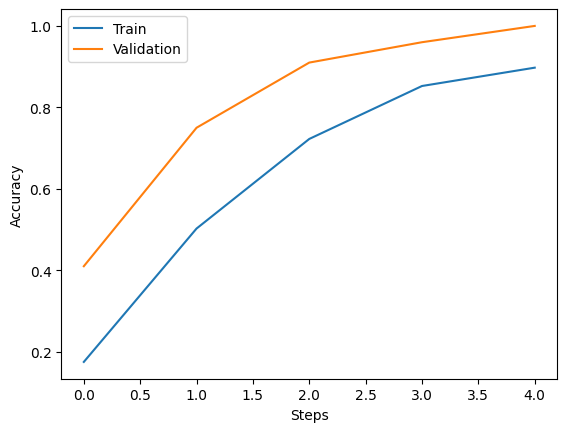

In [284]:
#Plotting train and validation history
steps = len(history.history['accuracy'])
plt.plot(np.arange(steps), history.history['accuracy'], label = 'Train')
plt.plot(np.arange(steps), history.history['val_accuracy'], label = 'Validation')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Accuracy')

In [285]:
def preprocess_image(image_path):
    # Loading the image
    img = Image.open(image_path).convert('RGB')  # Converting to RGB
    img = img.resize((224, 224), Image.LANCZOS)  # Resizing to 224x224
    img_array = np.array(img) / 255.0  # Normalizing to [0, 1]
    return img_array

def preprocess_images_from_folder(folder_path):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img_array = preprocess_image(img_path)
            images.append(img_array)
            filenames.append(filename)
    return np.array(images), filenames

folder_path = 'test_images' 
test_images, filenames = preprocess_images_from_folder(folder_path)

# Ensuring the shape of test_images is compatible with the model input
test_images = np.array(test_images)
if len(test_images.shape) == 3:  # Adding batch dimension if missing
    test_images = np.expand_dims(test_images, axis=0)

# Making predictions with the trained model
predictions = model.predict(test_images)

# Converting predictions to class labels and get the prediction confidence
predicted_labels = np.argmax(predictions, axis=1)
prediction_confidences = np.max(predictions, axis=1)

# Assuming you have a mapping from indices to labels
labels_map = {index: label for label, index in label_to_index.items()}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


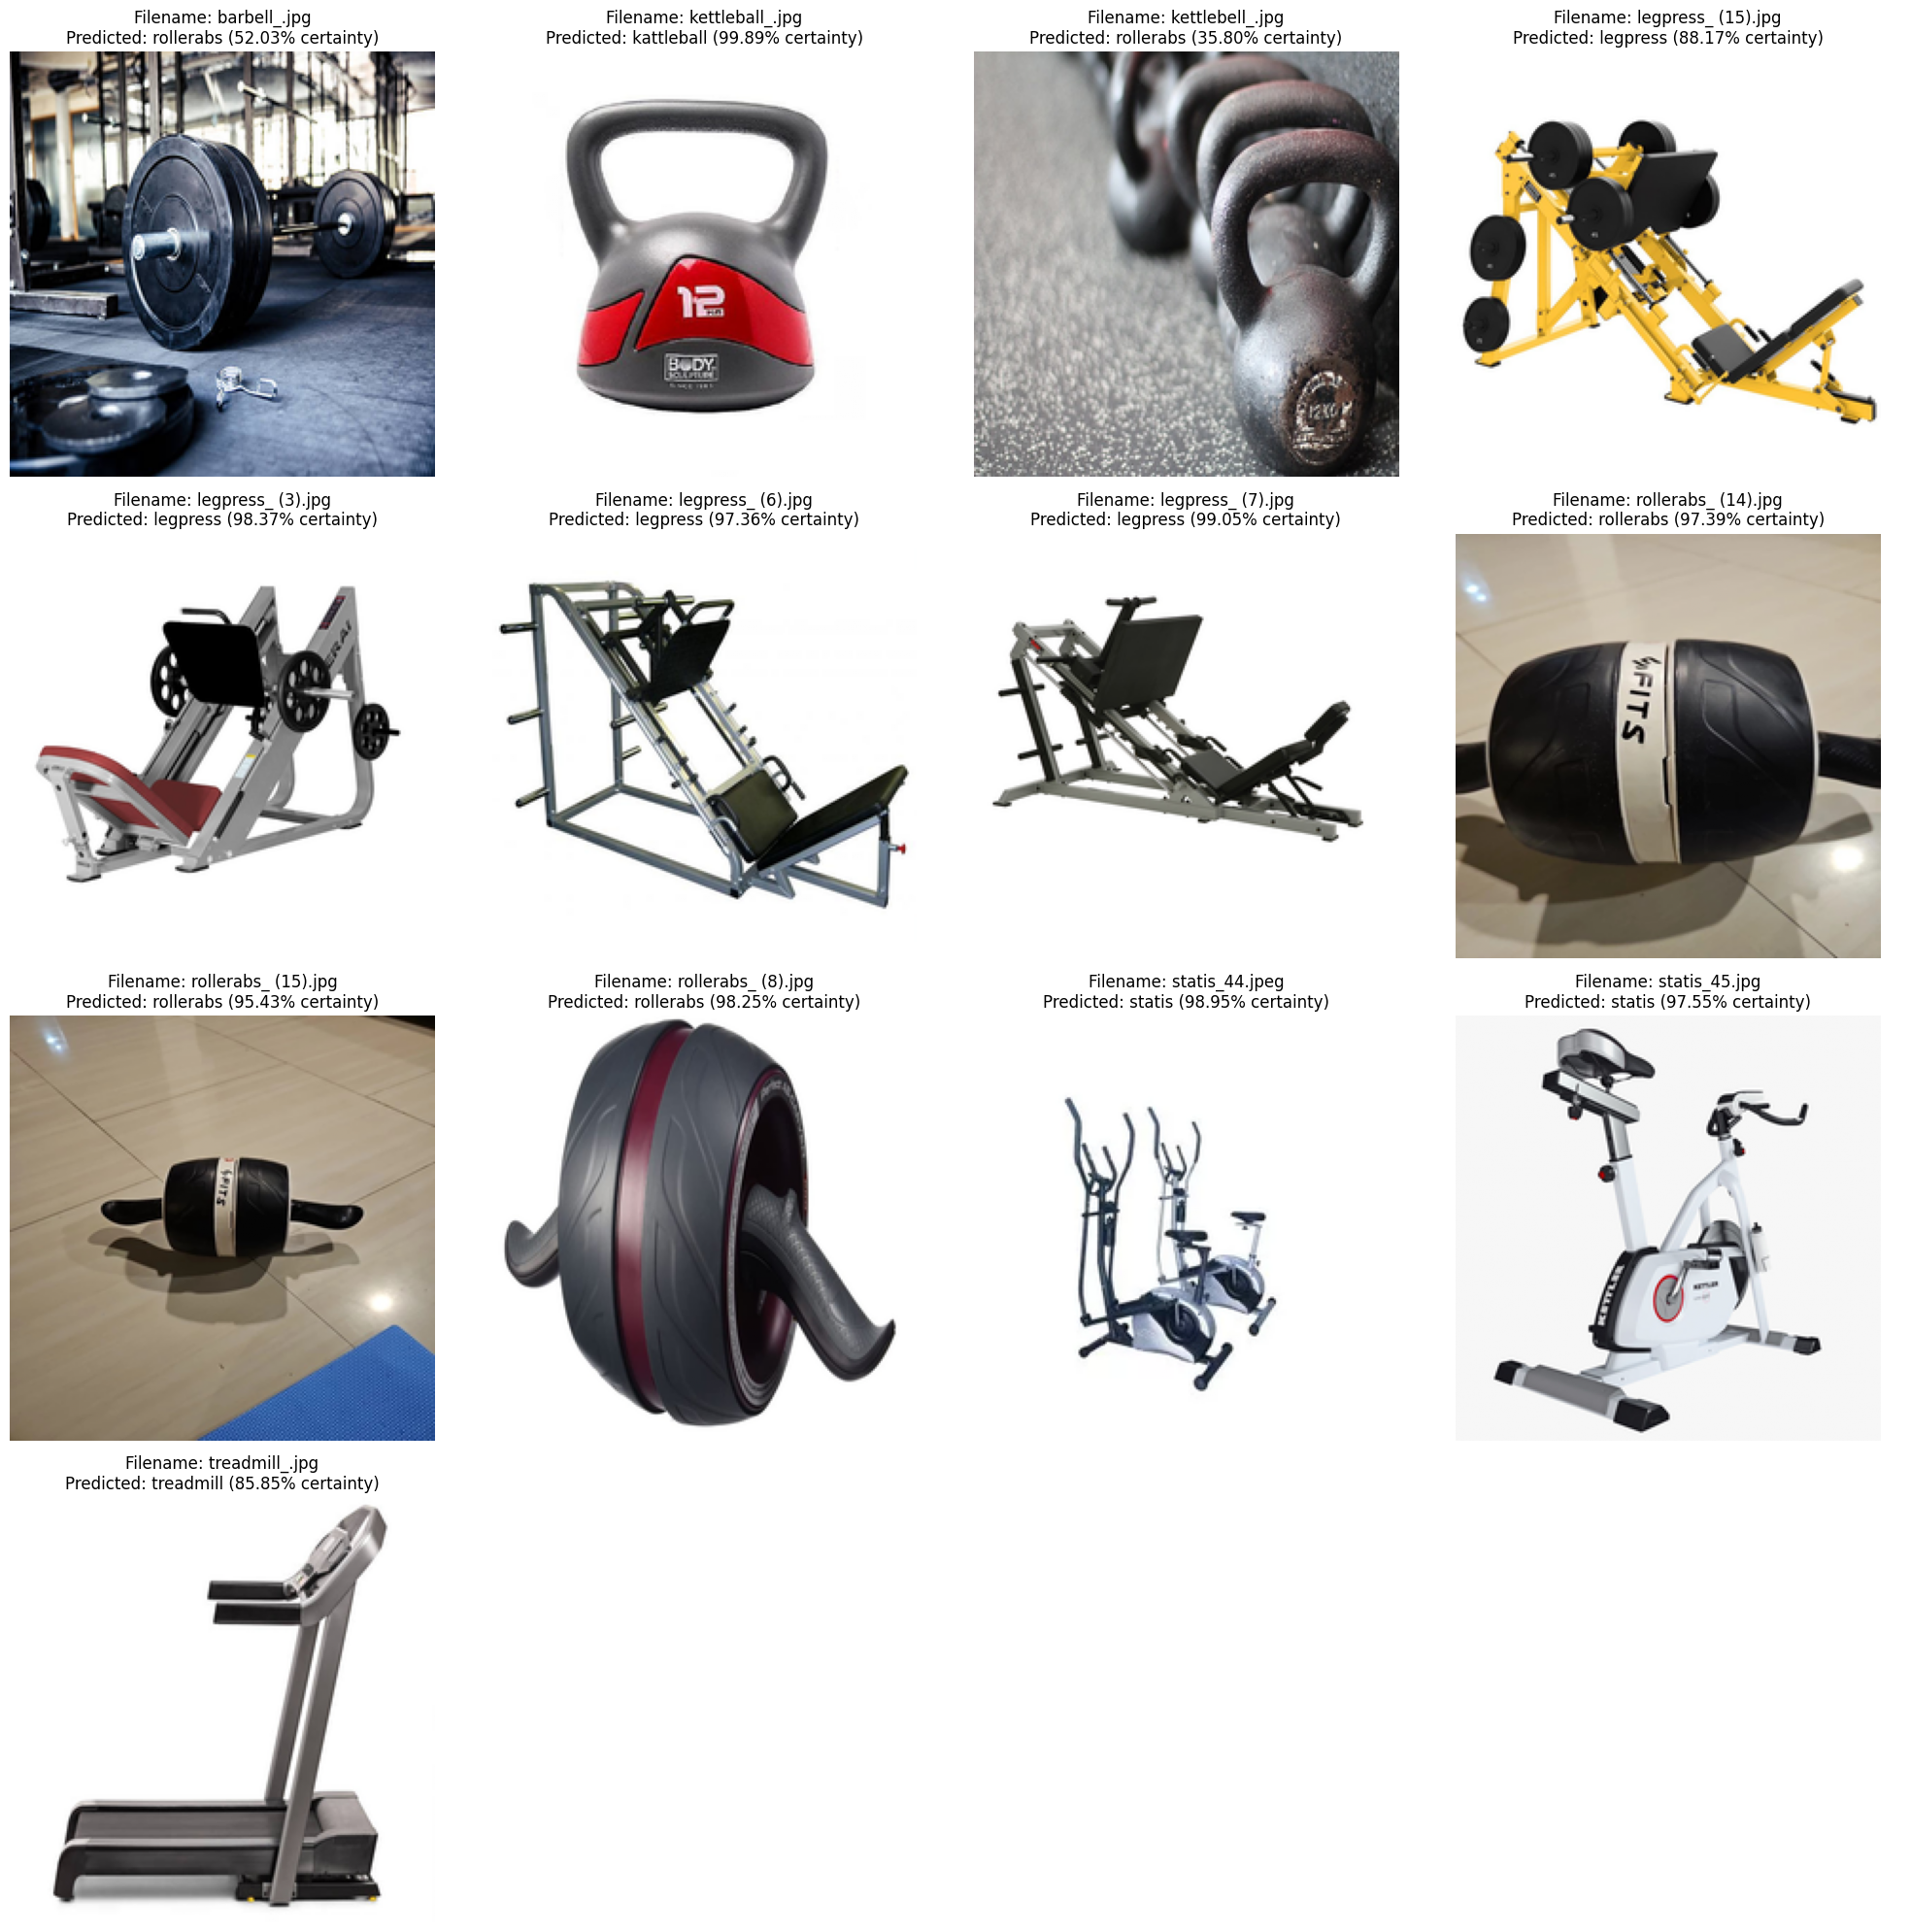

In [286]:
def display_predictions(images, predictions, confidences, filenames, labels_map, max_images_per_row=4):
    num_images = len(images)
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row  # Calculating the number of rows needed
    fig, axs = plt.subplots(num_rows, max_images_per_row, figsize=(max_images_per_row * 5, num_rows * 5))
    
    # Flattening axs for easy iteration
    axs = axs.flatten()
    
    for i in range(num_images):
        img = np.squeeze(images[i])  # Removing any singleton dimensions
        axs[i].imshow(img)
        axs[i].set_title(f"Filename: {filenames[i]}\nPredicted: {labels_map[predictions[i]]} ({confidences[i]*100:.2f}% certainty)")
        axs[i].axis('off')
    
    # Hiding any remaining subplots if the number of images is not a perfect multiple of max_images_per_row
    for j in range(num_images, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

display_predictions(test_images, predicted_labels, prediction_confidences, filenames, labels_map)


### Analysis of VGG16

The model performs well during training, and also has a relatively high accuracy on the test set.
Additionally for our manual testing where we selected random images from the dataset our customized VGG-16 Model managed to get the most results correctly with the highest confidence rating percentages on average